In [1]:
import time
import os
from os import listdir
from os.path import join, isfile
import glob
import numpy as np
import numpy.matlib
import pandas as pd
import pyedflib
from scipy.signal import find_peaks_cwt, welch
from scipy.signal import decimate
from datetime import timedelta
from datetime import datetime

from mne.filter import filter_data

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, hilbert, chirp
from scipy import signal
from scipy.fft import fft, ifft

In [7]:
class filtering():
    def __init__(self, bsWn=[49, 51], bpWn = [2, 9], hpWn=1, lpWn = 500,fs=2000):
        self.fs=fs
        self.bandstopWn = bsWn
        self.highpassWn= hpWn
        self.lowpassWn = lpWn 
        nyq = 0.5 * self.fs
        self.bandpassWn = np.array(bpWn)
       
        
    def downsample(self,data,proportion=0.4):
        return pd.Series(islice(data,0,len(data), int(1/proportion)))
    
    def highpass(self,data,order=5):
        b, a = signal.butter(order, self.highpassWn, 'highpass',fs = self.fs) 
        outputSignal = signal.filtfilt(b, a, data)
        return outputSignal

    def lowpass(self,data):
        b, a = signal.butter(4, self.lowpassWn, 'lowpass', fs = self.fs)
        y = signal.filtfilt(b, a, data)
        return y
    
    def bandstop(self,data):
        b, a = signal.butter(4, self.bandstopWn, 'bandstop',fs = self.fs)
        outputSignal = signal.filtfilt(b, a, data)
        return outputSignal 
    
    def bandpass(self, data): 
        b, a = signal.butter(4, self.bandpassWn, 'bandpass', fs = self.fs)
        outputSignal = signal.filtfilt(b, a, data)
        return outputSignal 
        
        
    def rectify(self, to_rectify):
        return abs(to_rectify)    
    
    def cutofftail(self,data, obsCutOffSec=10):
         return data[:-obsCutOffSec * self.fs]
    
    def ADC(self, data):
        return 3.3/8191*data

In [5]:
CompleteRL=np.load('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/numpyRightLeft.npy').astype(np.float64)

In [6]:
CompleteRL.shape

(7670321, 12)

In [10]:
fs = 100
filter_ = filtering(hpWn = 0.3, bpWn = [0.3 , 9],lpWn = 9, fs=fs)
after_filter = filter_.bandpass(CompleteRL[:,0])

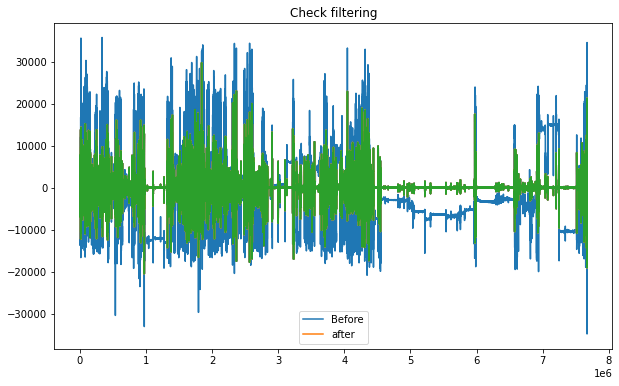

In [26]:
fig=plt.figure(figsize=(10,6))
plt.plot(CompleteRL[:,0])
plt.plot(after_filter)
plt.legend(['Before','after'])
plt.title('Check filtering')
plt.show()

In [21]:
after_filter=np.empty((CompleteRL.shape))
for axis in range(CompleteRL.shape[1]):
    after_filter[:,axis] = filter_.bandpass(CompleteRL[:,0])
# np.save('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/after_filter.npy',after_filter) 

## Divide data into files

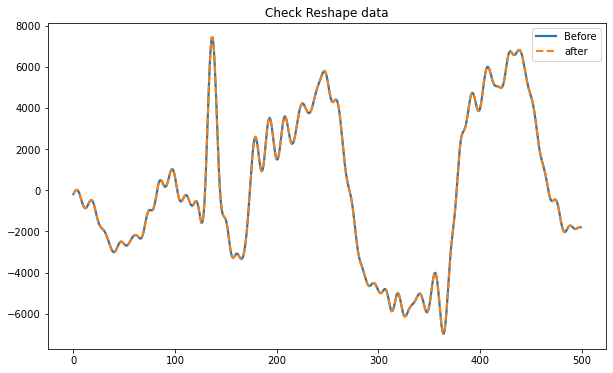

In [80]:
fig=plt.figure(figsize=(10,6))
plt.plot(reshaped_test[0,:],linewidth=2.2)
plt.plot(test[0:500],'--',linewidth=2)
plt.legend(['Before','after'])
plt.title('Check Reshape data')
plt.show()

In [91]:
# we are interested in having the 15 minute files:
filename = 1
abbriv = 1
PATH ='/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/ParagitBagData/'
for files in range(round(after_filter.shape[0]/(15*60*100))):
    
    ## getting every 15 minutes
    temp = after_filter[90000*files:90000*(files+1)]
    
    ## new dimension
    a = np.empty((180,500,12))

    for axis in range(after_filter.shape[1]):
        reshaped_test = np.reshape(np.ravel(temp[:,axis]), (180, 500))
        a[:,:,axis]=reshaped_test
    
    # save file with names: 
    np.save(PATH+str(abbriv)+'_'+str(filename)+'.npy',a)
    
    # name updates
    filename += 1
    if (files+1)% 4 == 0:
        filename = 1
        abbriv += 1

## Stanardize The data


In [17]:
paths = glob.glob("/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/ParagitBagData/*.npy")

for p in paths:
    data = np.load(p).astype(np.float64)
    acc_data = data[:,:,[0,1,2,6,7,8]];
    gyr_data = data[:,:,[3,4,5,9,10,11]];
    mu_acc = np.mean(acc_data);
    sd_acc = np.std(acc_data);
    mu_gyr = np.mean(gyr_data);
    sd_gyr = np.std(gyr_data);

    data[:, :, [0,1,2,6,7,8]] = (acc_data - mu_acc)/sd_acc;
    data[:, :, [3,4,5,9,10,11]] = (gyr_data - mu_gyr) / sd_gyr;
    #np.save(p.replace("ParagitBagData", "ParagitDataStd"), data)
